In [1]:
from utils import *

VISUALIZE_EMBEDDINGS = False #True

## Prepare Data

In [2]:
all_data = prepare_full_MNIST_databunch()
toytest = ToyAnomalyDetection(all_data, n_anomaly_labels=7, n_cases=10, distance='cosine')

## 1. Conventional softmax model

In [3]:
# Define model learner
def learner_conventional(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(3)
    return learn

def visualize_learner_embeddings(learn, title):
    embs = get_embeddings(body_feature_model(learn.model), all_data.valid_dl)
    show_2D_tSNE(embs, [int(y) for y in all_data.valid_ds.y], title=title)

if VISUALIZE_EMBEDDINGS:
    learn = learner_conventional(all_data)
    visualize_learner_embeddings(learn, 'Simply trained ResNet18 (t-SNE)')    

In [4]:
# Test model
toytest.do_tests('Conventional', learner_conventional)

Testing Conventional for case #0


epoch,train_loss,valid_loss,accuracy,time
0,0.427568,0.415273,0.840917,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.079924,0.043233,0.982730,00:05
1,0.036001,0.018506,0.995018,00:05
2,0.014761,0.008611,0.997011,00:05


Evaluation size => test:(4999, 512), train(9031, 512)
Calculated distances in shape (4999, 9031)
Testing Conventional for case #1


epoch,train_loss,valid_loss,accuracy,time
0,0.391276,0.323834,0.884914,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.066309,0.030005,0.990550,00:05
1,0.023767,0.017840,0.994600,00:05
2,0.014404,0.009692,0.996625,00:05


Evaluation size => test:(4999, 512), train(8860, 512)
Calculated distances in shape (4999, 8860)
Testing Conventional for case #2


epoch,train_loss,valid_loss,accuracy,time
0,0.201496,0.105301,0.962548,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.039510,0.007239,0.997119,00:05
1,0.016196,0.006133,0.998720,00:05
2,0.006155,0.001195,0.999680,00:05


Evaluation size => test:(4999, 512), train(9306, 512)
Calculated distances in shape (4999, 9306)
Testing Conventional for case #3


epoch,train_loss,valid_loss,accuracy,time
0,0.164830,0.113545,0.967588,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.046039,0.007474,0.998729,00:05
1,0.015352,0.002511,0.999364,00:05
2,0.004910,0.002046,0.999364,00:05


Evaluation size => test:(4999, 512), train(9311, 512)
Calculated distances in shape (4999, 9311)
Testing Conventional for case #4


epoch,train_loss,valid_loss,accuracy,time
0,0.313886,0.233497,0.910608,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.070810,0.014581,0.994964,00:05
1,0.022971,0.007645,0.997482,00:05
2,0.009527,0.004177,0.998741,00:05


Evaluation size => test:(4999, 512), train(9415, 512)
Calculated distances in shape (4999, 9415)
Testing Conventional for case #5


epoch,train_loss,valid_loss,accuracy,time
0,0.391127,0.291011,0.889220,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.061524,0.013415,0.995701,00:05
1,0.019971,0.005635,0.997685,00:05
2,0.010509,0.001639,0.999669,00:05


Evaluation size => test:(4999, 512), train(8965, 512)
Calculated distances in shape (4999, 8965)
Testing Conventional for case #6


epoch,train_loss,valid_loss,accuracy,time
0,0.365005,0.259536,0.907073,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.063833,0.021587,0.994105,00:05
1,0.032246,0.009879,0.997573,00:05
2,0.013383,0.004402,0.998266,00:05


Evaluation size => test:(4999, 512), train(8696, 512)
Calculated distances in shape (4999, 8696)
Testing Conventional for case #7


epoch,train_loss,valid_loss,accuracy,time
0,0.292787,0.184965,0.936441,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.056133,0.014845,0.994703,00:05
1,0.029143,0.013809,0.995410,00:05
2,0.012012,0.008342,0.996822,00:05


Evaluation size => test:(4999, 512), train(8590, 512)
Calculated distances in shape (4999, 8590)
Testing Conventional for case #8


epoch,train_loss,valid_loss,accuracy,time
0,0.315436,0.221706,0.921821,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.055214,0.013033,0.994788,00:05
1,0.021098,0.006420,0.997915,00:05
2,0.005686,0.003056,0.999305,00:05


Evaluation size => test:(4999, 512), train(8801, 512)
Calculated distances in shape (4999, 8801)
Testing Conventional for case #9


epoch,train_loss,valid_loss,accuracy,time
0,0.279370,0.209263,0.921959,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.062482,0.031521,0.989189,00:05
1,0.019036,0.005458,0.997973,00:05
2,0.008189,0.003407,0.998986,00:05


Evaluation size => test:(4999, 512), train(9016, 512)
Calculated distances in shape (4999, 9016)


In [5]:
distance_df, (auc, fpr, tpr), worst_test_info = toytest.results['Conventional'][0]
worst_test_info

,x,y,distance,train_idx,train_x,train_y
1961,4/img4_004519.png,4,0.001126,2481,9/img9_004306.png,9
2306,4/img4_004382.png,4,0.001372,2169,9/img9_022672.png,9
2180,4/img4_002771.png,4,0.002242,380,9/img9_032821.png,9
2181,4/img4_002130.png,4,0.002258,1845,9/img9_022765.png,9
2376,4/img4_004414.png,4,0.002552,539,9/img9_028383.png,9


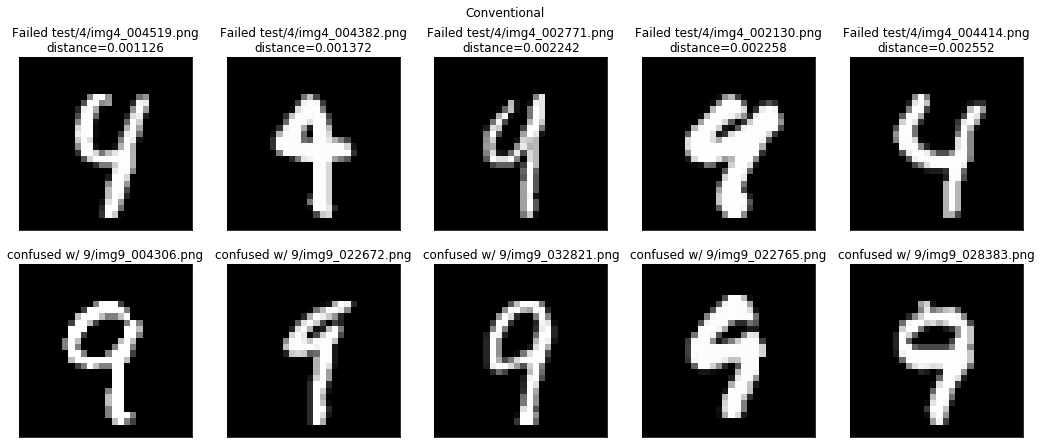

In [6]:
toytest.show_worst_test_images('Conventional', worst_test_info, 0)

## 2. L2-constrained Softmax Loss

- R. Ranjan, C. D. Castillo, and R. Chellappa. L2-constrained softmax loss for discriminative face verification. arXiv preprint arXiv:1703.09507, 2017. https://arxiv.org/pdf/1703.09507.pdf

In [7]:
# Define model learner
class L2ConstrainedNet(nn.Module):
    def __init__(self, org_model, alpha=16, num_classes=1000):
        super().__init__()
        self.org_model = org_model
        self.alpha = alpha

    def forward(self, x):
        x = self.org_model(x)
        
        l2 = torch.sqrt((x**2).sum())
        x = self.alpha * (x / l2)
        return x

def learner_L2ConstrainedNet(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = L2ConstrainedNet(learn.model)
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_learner_embeddings(learner_L2ConstrainedNet(all_data), 'L2 constrained ResNet18 (t-SNE)')

In [8]:
toytest.do_tests('L2-constrained', learner_L2ConstrainedNet)

Testing L2-constrained for case #0


epoch,train_loss,valid_loss,accuracy,time
0,0.490147,0.474736,0.843574,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.214074,0.180460,0.991697,00:05
1,0.191681,0.181786,0.990037,00:05
2,0.187141,0.169623,0.994686,00:05
3,0.175817,0.163721,0.997343,00:05
4,0.173273,0.163106,0.997343,00:05


Evaluation size => test:(4999, 512), train(9031, 512)
Calculated distances in shape (4999, 9031)
Testing L2-constrained for case #1


epoch,train_loss,valid_loss,accuracy,time
0,0.452286,0.390847,0.893351,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.215388,0.173317,0.993925,00:05
1,0.188100,0.165889,0.995950,00:05
2,0.182121,0.164906,0.996288,00:05
3,0.174895,0.160760,0.998650,00:05
4,0.172632,0.160806,0.998987,00:05


Evaluation size => test:(4999, 512), train(8860, 512)
Calculated distances in shape (4999, 8860)
Testing L2-constrained for case #2


epoch,train_loss,valid_loss,accuracy,time
0,0.324190,0.274356,0.965109,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.191344,0.165283,0.997759,00:05
1,0.179752,0.162968,0.999040,00:05
2,0.176599,0.159376,1.000000,00:05
3,0.172685,0.159700,0.999680,00:05
4,0.169200,0.159458,0.999360,00:05


Evaluation size => test:(4999, 512), train(9306, 512)
Calculated distances in shape (4999, 9306)
Testing L2-constrained for case #3


epoch,train_loss,valid_loss,accuracy,time
0,0.300898,0.272975,0.961551,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.195801,0.170159,0.995551,00:05
1,0.184156,0.171084,0.993009,00:05
2,0.175405,0.160884,0.998729,00:05
3,0.171248,0.161121,0.999047,00:05
4,0.170757,0.160818,0.999047,00:05


Evaluation size => test:(4999, 512), train(9311, 512)
Calculated distances in shape (4999, 9311)
Testing L2-constrained for case #4


epoch,train_loss,valid_loss,accuracy,time
0,0.398118,0.353237,0.909978,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.204814,0.167398,0.997167,00:05
1,0.185034,0.163062,0.998426,00:05
2,0.180941,0.165529,0.996223,00:05
3,0.175486,0.161907,0.997797,00:05
4,0.171141,0.160048,0.999370,00:05


Evaluation size => test:(4999, 512), train(9415, 512)
Calculated distances in shape (4999, 9415)
Testing L2-constrained for case #5


epoch,train_loss,valid_loss,accuracy,time
0,0.459026,0.391390,0.891534,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.210735,0.171736,0.995040,00:05
1,0.193323,0.168675,0.997024,00:05
2,0.177812,0.163093,0.998016,00:05
3,0.172196,0.159821,0.999339,00:05
4,0.170122,0.160137,0.999339,00:05


Evaluation size => test:(4999, 512), train(8965, 512)
Calculated distances in shape (4999, 8965)
Testing L2-constrained for case #6


epoch,train_loss,valid_loss,accuracy,time
0,0.430251,0.380637,0.902219,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.204677,0.171863,0.996533,00:05
1,0.186864,0.167483,0.996533,00:05
2,0.180245,0.162834,0.997920,00:05
3,0.174674,0.162192,0.998613,00:05
4,0.171861,0.162223,0.998613,00:05


Evaluation size => test:(4999, 512), train(8696, 512)
Calculated distances in shape (4999, 8696)
Testing L2-constrained for case #7


epoch,train_loss,valid_loss,accuracy,time
0,0.402892,0.345657,0.919492,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.204869,0.168383,0.996469,00:05
1,0.191111,0.169046,0.996469,00:05
2,0.176528,0.164562,0.995763,00:05
3,0.172984,0.161296,0.998234,00:05
4,0.171264,0.160798,0.998234,00:05


Evaluation size => test:(4999, 512), train(8590, 512)
Calculated distances in shape (4999, 8590)
Testing L2-constrained for case #8


epoch,train_loss,valid_loss,accuracy,time
0,0.420489,0.362549,0.912092,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.202633,0.168607,0.998263,00:05
1,0.181024,0.166437,0.996525,00:05
2,0.177044,0.165663,0.996873,00:05
3,0.172319,0.163059,0.998263,00:05
4,0.171164,0.162273,0.998610,00:05


Evaluation size => test:(4999, 512), train(8801, 512)
Calculated distances in shape (4999, 8801)
Testing L2-constrained for case #9


epoch,train_loss,valid_loss,accuracy,time
0,0.385093,0.333633,0.927703,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.204350,0.174694,0.996622,00:05
1,0.185296,0.165441,0.997635,00:05
2,0.177308,0.159923,0.999324,00:05
3,0.171327,0.160409,0.999324,00:05
4,0.169752,0.160258,0.999324,00:05


Evaluation size => test:(4999, 512), train(9016, 512)
Calculated distances in shape (4999, 9016)


## 3. ArcFace

- J. Deng, J. Guo, and S. Zafeiriou. Arcface: Additive angular margin loss for deep face recognition. arXiv preprint arXiv:1801.07698, 2018. https://arxiv.org/pdf/1801.07698.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

In [9]:
try:
    from metrics import *
except:
    ! wget https://raw.githubusercontent.com/ronghuaiyang/arcface-pytorch/master/models/metrics.py
    from metrics import *

In [10]:
class LabelCatcher(LearnerCallback):
    last_labels = None

    def __init__(self, learn:Learner):
        super().__init__(learn)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        LabelCatcher.last_labels = last_target
        return {'last_input': last_input, 'last_target': last_target} 


class XFaceNet(nn.Module):
    def __init__(self, org_model, data, xface_product=ArcMarginProduct, m=0.5):
        super().__init__()
        self.org_model = org_model
        self.feature_model = body_feature_model(org_model)
        self.metric_fc = xface_product(512, data.c, m=m).cuda()
    
    def forward(self, x):
        x = self.feature_model(x)
        x = self.metric_fc(x, LabelCatcher.last_labels)
        return x


def learner_ArcFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, ArcMarginProduct, m=0.5)
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_learner_embeddings(learner_ArcFace(all_data), 'ArcFace (t-SNE)')

In [11]:
toytest.do_tests('ArcFace', learner_ArcFace)

Testing ArcFace for case #0


epoch,train_loss,valid_loss,accuracy,time
0,4.616258,4.312649,0.748256,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.840617,0.584802,0.977084,00:05
1,0.690478,0.701053,0.966456,00:05
2,0.464247,0.163348,0.994022,00:05
3,0.248119,0.117374,0.995018,00:05
4,0.110559,0.100338,0.995682,00:05


Evaluation size => test:(4999, 512), train(9031, 512)
Calculated distances in shape (4999, 9031)
Testing ArcFace for case #1


epoch,train_loss,valid_loss,accuracy,time
0,3.745940,2.902755,0.829227,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.774681,0.397450,0.982788,00:05
1,0.479559,0.242038,0.991900,00:05
2,0.299745,0.187359,0.993588,00:05
3,0.132889,0.059028,0.996963,00:05
4,0.085538,0.043664,0.997300,00:05


Evaluation size => test:(4999, 512), train(8860, 512)
Calculated distances in shape (4999, 8860)
Testing ArcFace for case #2


epoch,train_loss,valid_loss,accuracy,time
0,1.897195,1.049320,0.936940,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.314064,0.101793,0.994558,00:05
1,0.252885,0.091010,0.996479,00:05
2,0.208482,0.044711,0.997439,00:05
3,0.092922,0.027100,0.999360,00:05
4,0.043046,0.011181,0.999040,00:05


Evaluation size => test:(4999, 512), train(9306, 512)
Calculated distances in shape (4999, 9306)
Testing ArcFace for case #3


epoch,train_loss,valid_loss,accuracy,time
0,1.597437,1.068467,0.934223,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.505870,0.411672,0.982841,00:05
1,0.265749,0.068736,0.997458,00:05
2,0.202389,0.082843,0.996822,00:05
3,0.091718,0.047153,0.998729,00:05
4,0.048072,0.037231,0.998729,00:05


Evaluation size => test:(4999, 512), train(9311, 512)
Calculated distances in shape (4999, 9311)
Testing ArcFace for case #4


epoch,train_loss,valid_loss,accuracy,time
0,3.200940,2.223873,0.856154,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.617092,0.255584,0.987095,00:05
1,0.353533,0.204599,0.993705,00:05
2,0.193280,0.066146,0.996852,00:05
3,0.105044,0.035097,0.998426,00:05
4,0.096233,0.020884,0.999056,00:05


Evaluation size => test:(4999, 512), train(9415, 512)
Calculated distances in shape (4999, 9415)
Testing ArcFace for case #5


epoch,train_loss,valid_loss,accuracy,time
0,3.788853,2.606318,0.829696,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.641525,0.220858,0.991071,00:05
1,0.334794,0.101598,0.995040,00:05
2,0.239525,0.093501,0.996362,00:05
3,0.102464,0.014708,0.999008,00:05
4,0.046570,0.016034,0.998347,00:05


Evaluation size => test:(4999, 512), train(8965, 512)
Calculated distances in shape (4999, 8965)
Testing ArcFace for case #6


epoch,train_loss,valid_loss,accuracy,time
0,3.514644,2.735799,0.852288,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.607138,0.184458,0.988558,00:05
1,0.439471,0.151685,0.994452,00:05
2,0.244999,0.069479,0.997920,00:05
3,0.074856,0.066945,0.997573,00:05
4,0.058635,0.062340,0.997920,00:05


Evaluation size => test:(4999, 512), train(8696, 512)
Calculated distances in shape (4999, 8696)
Testing ArcFace for case #7


epoch,train_loss,valid_loss,accuracy,time
0,3.201081,1.803543,0.868997,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.618354,0.246286,0.990466,00:05
1,0.392940,0.219557,0.991879,00:05
2,0.208874,0.099450,0.996116,00:05
3,0.126324,0.108371,0.995410,00:05
4,0.064494,0.078050,0.996822,00:05


Evaluation size => test:(4999, 512), train(8590, 512)
Calculated distances in shape (4999, 8590)
Testing ArcFace for case #8


epoch,train_loss,valid_loss,accuracy,time
0,3.231576,2.179849,0.849201,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.487374,0.250083,0.989576,00:05
1,0.339697,0.083732,0.996873,00:05
2,0.224532,0.096150,0.997220,00:05
3,0.109049,0.027748,0.999305,00:05
4,0.080032,0.024038,0.998610,00:05


Evaluation size => test:(4999, 512), train(8801, 512)
Calculated distances in shape (4999, 8801)
Testing ArcFace for case #9


epoch,train_loss,valid_loss,accuracy,time
0,2.750159,2.143338,0.868243,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.610964,0.295015,0.987500,00:05
1,0.327644,0.162383,0.994595,00:05
2,0.192350,0.038551,0.998311,00:05
3,0.175081,0.054842,0.998311,00:05
4,0.039768,0.017858,0.998649,00:05


Evaluation size => test:(4999, 512), train(9016, 512)
Calculated distances in shape (4999, 9016)


## 4. CosFace
- H. Wang, Y. Wang, Z. Zhou, X. Ji, D. Gong, J. Zhou, Z. Li, and W. Liu, CosFace: Large Margin Cosine Loss for Deep Face Recognition, arXiv preprint arXiv:1801.09414, 2018. https://arxiv.org/pdf/1801.09414.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

In [12]:
def learner_CosFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, AddMarginProduct, m=0.4)
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_learner_embeddings(learner_CosFace(all_data), 'CosFace (t-SNE)')

In [13]:
toytest.do_tests('CosFace', learner_CosFace)

Testing CosFace for case #0


epoch,train_loss,valid_loss,accuracy,time
0,3.874786,3.637154,0.756227,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.799759,0.552055,0.969445,00:05
1,0.502438,0.288505,0.987380,00:05
2,0.334793,0.287568,0.987380,00:05
3,0.117994,0.101020,0.996347,00:05
4,0.121967,0.075952,0.996015,00:05


Evaluation size => test:(4999, 512), train(9031, 512)
Calculated distances in shape (4999, 9031)
Testing CosFace for case #1


epoch,train_loss,valid_loss,accuracy,time
0,3.196984,2.630650,0.827202,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.692356,0.604368,0.976375,00:05
1,0.395106,0.167753,0.992913,00:05
2,0.279240,0.140274,0.994263,00:05
3,0.137414,0.063492,0.996963,00:05
4,0.065579,0.048042,0.998313,00:05


Evaluation size => test:(4999, 512), train(8860, 512)
Calculated distances in shape (4999, 8860)
Testing CosFace for case #2


epoch,train_loss,valid_loss,accuracy,time
0,1.574822,0.915000,0.935659,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.333691,0.123262,0.991037,00:05
1,0.196076,0.032950,0.998399,00:05
2,0.157578,0.032506,0.997439,00:05
3,0.050227,0.011255,0.999680,00:05
4,0.018714,0.008454,0.999680,00:05


Evaluation size => test:(4999, 512), train(9306, 512)
Calculated distances in shape (4999, 9306)
Testing CosFace for case #3


epoch,train_loss,valid_loss,accuracy,time
0,1.405911,0.964003,0.932634,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.425092,0.203231,0.990785,00:05
1,0.304037,0.191089,0.992374,00:05
2,0.118339,0.040280,0.998411,00:05
3,0.082732,0.055898,0.998093,00:05
4,0.046553,0.050413,0.998093,00:05


Evaluation size => test:(4999, 512), train(9311, 512)
Calculated distances in shape (4999, 9311)
Testing CosFace for case #4


epoch,train_loss,valid_loss,accuracy,time
0,2.657398,1.942781,0.856468,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.519086,0.220734,0.988354,00:05
1,0.359242,0.309028,0.988039,00:05
2,0.246640,0.050571,0.998111,00:05
3,0.080028,0.098544,0.995908,00:05
4,0.053534,0.058206,0.997482,00:05


Evaluation size => test:(4999, 512), train(9415, 512)
Calculated distances in shape (4999, 9415)
Testing CosFace for case #5


epoch,train_loss,valid_loss,accuracy,time
0,3.388957,2.432968,0.811508,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.644349,0.127023,0.992063,00:05
1,0.447767,0.379683,0.984127,00:05
2,0.266489,0.078845,0.996362,00:05
3,0.087274,0.037481,0.998347,00:05
4,0.060786,0.027516,0.998677,00:05


Evaluation size => test:(4999, 512), train(8965, 512)
Calculated distances in shape (4999, 8965)
Testing CosFace for case #6


epoch,train_loss,valid_loss,accuracy,time
0,2.979252,2.186186,0.859570,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.387641,0.124758,0.993065,00:05
1,0.323348,0.163009,0.992025,00:05
2,0.162829,0.048627,0.997573,00:05
3,0.121827,0.116740,0.995492,00:05
4,0.066504,0.078915,0.996533,00:05


Evaluation size => test:(4999, 512), train(8696, 512)
Calculated distances in shape (4999, 8696)
Testing CosFace for case #7


epoch,train_loss,valid_loss,accuracy,time
0,2.550205,1.571911,0.872175,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.394953,0.211600,0.990113,00:05
1,0.233102,0.153445,0.994350,00:05
2,0.174210,0.048025,0.997528,00:05
3,0.119943,0.109176,0.996116,00:05
4,0.060547,0.037720,0.997881,00:05


Evaluation size => test:(4999, 512), train(8590, 512)
Calculated distances in shape (4999, 8590)
Testing CosFace for case #8


epoch,train_loss,valid_loss,accuracy,time
0,2.716200,1.954620,0.845379,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.369016,0.114229,0.994788,00:05
1,0.292226,0.091137,0.997220,00:05
2,0.142633,0.068803,0.997220,00:05
3,0.070760,0.046093,0.997915,00:05
4,0.065750,0.018971,0.998263,00:05


Evaluation size => test:(4999, 512), train(8801, 512)
Calculated distances in shape (4999, 8801)
Testing CosFace for case #9


epoch,train_loss,valid_loss,accuracy,time
0,2.401106,2.134723,0.855068,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.443119,0.108209,0.993243,00:05
1,0.267580,0.109755,0.994595,00:05
2,0.174762,0.022515,0.998311,00:05
3,0.104972,0.030678,0.997635,00:05
4,0.045001,0.012685,0.999324,00:05


Evaluation size => test:(4999, 512), train(9016, 512)
Calculated distances in shape (4999, 9016)


## 5. SphereFace

- W. Liu, Y. Wen, Z. Yu, M. Li, B. Raj, and L. Song. SphereFace: Deep Hypersphere Embedding for Face Recognition. In CVPR, 2017. https://arxiv.org/pdf/1704.08063.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

In [14]:
def learner_SphereFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, SphereProduct, m=int(4))
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_learner_embeddings(learner_SphereFace(all_data), 'SphereFace (t-SNE)')

In [15]:
toytest.do_tests('ShpereFace', learner_SphereFace)

Testing ShpereFace for case #0


epoch,train_loss,valid_loss,accuracy,time
0,0.682996,0.569284,0.783128,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.151280,0.040200,0.989372,00:05
1,0.075777,0.024906,0.994022,00:05
2,0.052929,0.016664,0.996347,00:05
3,0.030924,0.010825,0.998007,00:05
4,0.023439,0.011381,0.997011,00:05


Evaluation size => test:(4999, 512), train(9031, 512)
Calculated distances in shape (4999, 9031)
Testing ShpereFace for case #1


epoch,train_loss,valid_loss,accuracy,time
0,0.598798,0.470761,0.834290,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.142036,0.060785,0.983800,00:05
1,0.057186,0.016966,0.995613,00:05
2,0.042500,0.020356,0.996625,00:05
3,0.034803,0.005273,0.998313,00:05
4,0.013368,0.004763,0.998650,00:05


Evaluation size => test:(4999, 512), train(8860, 512)
Calculated distances in shape (4999, 8860)
Testing ShpereFace for case #2


epoch,train_loss,valid_loss,accuracy,time
0,0.294604,0.160459,0.949104,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.062213,0.011648,0.996799,00:05
1,0.040445,0.016785,0.996479,00:05
2,0.031495,0.038927,0.994238,00:05
3,0.011469,0.002368,0.999680,00:05
4,0.010862,0.001547,0.999680,00:05


Evaluation size => test:(4999, 512), train(9306, 512)
Calculated distances in shape (4999, 9306)
Testing ShpereFace for case #3


epoch,train_loss,valid_loss,accuracy,time
0,0.245599,0.191094,0.945027,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.085997,0.019691,0.993645,00:05
1,0.052227,0.015881,0.995869,00:05
2,0.026049,0.008205,0.998411,00:05
3,0.017178,0.001836,0.999682,00:05
4,0.005179,0.001974,0.999682,00:05


Evaluation size => test:(4999, 512), train(9311, 512)
Calculated distances in shape (4999, 9311)
Testing ShpereFace for case #4


epoch,train_loss,valid_loss,accuracy,time
0,0.459737,0.376609,0.859931,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.100310,0.013695,0.996852,00:05
1,0.046382,0.021633,0.994649,00:05
2,0.029753,0.008390,0.997482,00:05
3,0.024633,0.002337,0.999685,00:05
4,0.019427,0.001820,0.999685,00:05


Evaluation size => test:(4999, 512), train(9415, 512)
Calculated distances in shape (4999, 9415)
Testing ShpereFace for case #5


epoch,train_loss,valid_loss,accuracy,time
0,0.568156,0.444202,0.829696,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.107460,0.026671,0.992725,00:05
1,0.079394,0.024309,0.994378,00:05
2,0.036527,0.014185,0.997024,00:05
3,0.016810,0.005578,0.999008,00:05
4,0.016505,0.005123,0.999008,00:05


Evaluation size => test:(4999, 512), train(8965, 512)
Calculated distances in shape (4999, 8965)
Testing ShpereFace for case #6


epoch,train_loss,valid_loss,accuracy,time
0,0.501103,0.380489,0.866852,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.088113,0.027412,0.993412,00:05
1,0.070844,0.023849,0.995839,00:05
2,0.032080,0.012636,0.998266,00:05
3,0.023056,0.008741,0.997226,00:05
4,0.015809,0.007933,0.997573,00:05


Evaluation size => test:(4999, 512), train(8696, 512)
Calculated distances in shape (4999, 8696)
Testing ShpereFace for case #7


epoch,train_loss,valid_loss,accuracy,time
0,0.441925,0.287374,0.899718,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.095560,0.028887,0.991879,00:05
1,0.054002,0.025434,0.996469,00:05
2,0.032858,0.009308,0.997528,00:05
3,0.019675,0.008724,0.996822,00:05
4,0.013786,0.006966,0.997881,00:05


Evaluation size => test:(4999, 512), train(8590, 512)
Calculated distances in shape (4999, 8590)
Testing ShpereFace for case #8


epoch,train_loss,valid_loss,accuracy,time
0,0.426964,0.340975,0.878388,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.098884,0.012233,0.997568,00:05
1,0.053153,0.008038,0.998263,00:05
2,0.038957,0.031157,0.992703,00:05
3,0.011956,0.005624,0.998263,00:05
4,0.011580,0.003755,0.999305,00:05


Evaluation size => test:(4999, 512), train(8801, 512)
Calculated distances in shape (4999, 8801)
Testing ShpereFace for case #9


epoch,train_loss,valid_loss,accuracy,time
0,0.404801,0.321602,0.888514,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.092517,0.025808,0.992905,00:05
1,0.042949,0.006163,0.999324,00:05
2,0.030945,0.006482,0.998649,00:05
3,0.020224,0.003267,0.998649,00:05
4,0.011656,0.002385,0.999324,00:05


Evaluation size => test:(4999, 512), train(9016, 512)
Calculated distances in shape (4999, 9016)


## 6. Center Loss

- Y. Wen, K. Zhang, Z. Li, and Y. Qiao, A discriminative feature learning approach for deep face recognition,” in European Conference on Computer Vision. Springer, 2016, pp. 499–515. https://ydwen.github.io/papers/WenECCV16.pdf
- Pytorch implementation: https://github.com/KaiyangZhou/pytorch-center-loss

In [16]:
try:
    from center_loss import *
except:
    ! wget https://raw.githubusercontent.com/KaiyangZhou/pytorch-center-loss/master/center_loss.py
    from center_loss import *

In [17]:
class WrapCenterLoss(nn.Module):
    "CenterLoss wrapper for https://github.com/KaiyangZhou/pytorch-center-loss."
    
    def __init__(self, learn, data, weight_cent=1/10):
        super().__init__()
        self.org_loss = learn.loss_func
        self.center_loss = CenterLoss(data.c, data.c)
        self.weight_cent = weight_cent

    def forward(self, output, target):
        dL = self.org_loss(output, target)
        dC = self.center_loss(output, target)
        #print(dL, dC)
        d = dL + self.weight_cent * dC
        return d

def learner_CenterLoss(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.loss_func = WrapCenterLoss(learn, train_data, weight_cent=1/8) ## Hand tuned
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_learner_embeddings(learner_CenterLoss(all_data), 'CenterLoss (t-SNE)')

In [18]:
toytest.do_tests('CenterLoss', learner_CenterLoss)

Testing CenterLoss for case #0


epoch,train_loss,valid_loss,accuracy,time
0,0.965680,0.894514,0.737961,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.575214,0.505806,0.977416,00:05
1,0.528654,0.488316,0.991033,00:05
2,0.512157,0.475093,0.996679,00:05
3,0.505790,0.474511,0.998672,00:05
4,0.490587,0.478738,0.997343,00:05


Evaluation size => test:(4999, 512), train(9031, 512)
Calculated distances in shape (4999, 9031)
Testing CenterLoss for case #1


epoch,train_loss,valid_loss,accuracy,time
0,1.445262,1.409670,0.617617,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.287577,1.273675,0.656429,00:05
1,1.263427,1.265159,0.656429,00:05
2,1.269003,1.261764,0.658454,00:05
3,1.257032,1.261573,0.658792,00:05
4,1.257359,1.259575,0.658792,00:05


Evaluation size => test:(4999, 512), train(8860, 512)
Calculated distances in shape (4999, 8860)
Testing CenterLoss for case #2


epoch,train_loss,valid_loss,accuracy,time
0,0.634981,0.531854,0.952945,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.426533,0.410206,0.998720,00:05
1,0.401354,0.374062,0.999360,00:05
2,0.397562,0.379251,0.996799,00:05
3,0.387160,0.373373,1.000000,00:05
4,0.388568,0.372077,0.999680,00:05


Evaluation size => test:(4999, 512), train(9306, 512)
Calculated distances in shape (4999, 9306)
Testing CenterLoss for case #3


epoch,train_loss,valid_loss,accuracy,time
0,0.739874,0.670238,0.961233,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.552604,0.517156,0.995869,00:05
1,0.526137,0.509182,0.998729,00:05
2,0.524822,0.506540,0.997458,00:05
3,0.519629,0.502999,0.999364,00:05
4,0.516497,0.502737,0.999682,00:05


Evaluation size => test:(4999, 512), train(9311, 512)
Calculated distances in shape (4999, 9311)
Testing CenterLoss for case #4


epoch,train_loss,valid_loss,accuracy,time
0,1.072666,1.027531,0.859931,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.857768,0.831108,0.995593,00:05
1,0.846316,0.827883,0.997797,00:05
2,0.833885,0.825519,0.997797,00:05
3,0.828570,0.823890,0.998741,00:05
4,0.827055,0.822599,0.999370,00:05


Evaluation size => test:(4999, 512), train(9415, 512)
Calculated distances in shape (4999, 9415)
Testing CenterLoss for case #5


epoch,train_loss,valid_loss,accuracy,time
0,0.906815,0.791517,0.831019,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.413880,0.332915,0.996693,00:05
1,0.368782,0.315969,0.997685,00:05
2,0.349526,0.324712,0.996362,00:05
3,0.336368,0.311300,0.999339,00:05
4,0.333031,0.311180,0.999669,00:05


Evaluation size => test:(4999, 512), train(8965, 512)
Calculated distances in shape (4999, 8965)
Testing CenterLoss for case #6


epoch,train_loss,valid_loss,accuracy,time
0,0.949547,0.870358,0.848128,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.699745,0.677911,0.985090,00:05
1,0.684688,0.667145,0.996879,00:05
2,0.679003,0.660317,0.995839,00:05
3,0.672056,0.659015,0.998266,00:05
4,0.668835,0.657829,0.997573,00:05


Evaluation size => test:(4999, 512), train(8696, 512)
Calculated distances in shape (4999, 8696)
Testing CenterLoss for case #7


epoch,train_loss,valid_loss,accuracy,time
0,0.824334,0.712481,0.911017,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.554398,0.508159,0.993291,00:05
1,0.532483,0.502000,0.993644,00:05
2,0.515644,0.495391,0.997175,00:05
3,0.509828,0.491738,0.998941,00:05
4,0.508752,0.494042,0.997881,00:05


Evaluation size => test:(4999, 512), train(8590, 512)
Calculated distances in shape (4999, 8590)
Testing CenterLoss for case #8


epoch,train_loss,valid_loss,accuracy,time
0,0.822037,0.695462,0.897498,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.482592,0.435190,0.997220,00:05
1,0.450240,0.424499,0.997915,00:05
2,0.445091,0.422745,0.998263,00:05
3,0.435903,0.417680,0.998958,00:05
4,0.430892,0.416028,0.999305,00:05


Evaluation size => test:(4999, 512), train(8801, 512)
Calculated distances in shape (4999, 8801)
Testing CenterLoss for case #9


epoch,train_loss,valid_loss,accuracy,time
0,0.941740,0.866551,0.755743,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.746704,0.708141,0.993919,00:05
1,0.726003,0.719260,0.985811,00:05
2,0.721948,0.704089,0.995946,00:05
3,0.709764,0.700597,0.998986,00:05
4,0.712194,0.701327,0.998311,00:05


Evaluation size => test:(4999, 512), train(9016, 512)
Calculated distances in shape (4999, 9016)


# Summary

# Stat: AUC


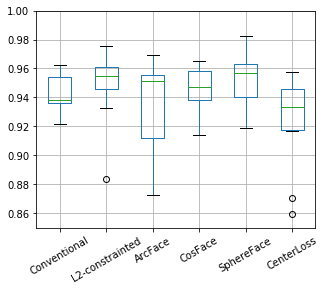

# Stat: Normalized distances


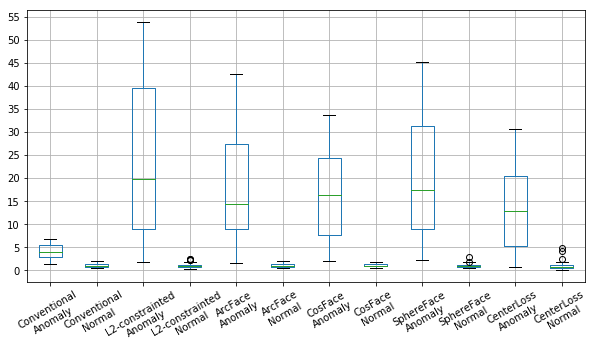


## [0, 1, 2, 3, 4, 5, 6]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphereFace,CenterLoss
<unk> 0,3.420296,22.220737,31.352536,25.106977,32.303544,28.869381
<unk> 1,3.514375,39.285292,14.313557,33.067506,16.980776,16.054428
<unk> 2,5.504621,48.888668,22.342864,27.022635,34.407042,30.552742
<unk> 3,6.685326,39.721561,13.723621,19.797191,30.563166,23.213674
<unk> 4,6.142357,43.595405,35.755998,27.553666,27.306359,20.122746
<unk> 5,4.642300,30.322808,14.136697,17.446094,22.571446,10.502185
<unk> 6,3.605787,7.136852,2.855890,2.706338,9.392019,11.458839
7,1.316080,0.823805,1.313714,1.362436,1.376418,0.400833
8,1.336341,2.344585,0.968948,0.945477,2.745086,4.026370
9,0.419144,0.941879,1.984003,0.668006,1.039113,0.545116



## [1, 2, 3, 4, 5, 6, 7]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphereFace,CenterLoss
0,0.902193,0.759128,1.053492,1.042290,1.284377,4.845731
<unk> 1,6.625215,52.808574,36.210334,25.928182,43.243139,24.579058
<unk> 2,4.003904,13.569897,15.208598,8.443866,9.167958,11.731125
<unk> 3,5.571472,43.077560,26.310697,17.595066,33.068986,21.323783
<unk> 4,2.408273,13.508003,8.521671,7.488909,8.888359,10.119556
<unk> 5,5.464888,32.078959,16.130659,16.044071,29.407283,18.879284
<unk> 6,4.709588,31.290490,28.022412,21.449079,30.672760,26.542654
<unk> 7,1.492723,4.806384,5.433698,3.838407,4.589668,4.696548
8,1.172817,0.837789,1.679472,0.976772,0.875704,0.864545
9,0.654989,1.099541,1.229699,1.164011,0.723989,1.636967



## [2, 3, 4, 5, 6, 7, 8]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphereFace,CenterLoss
0,0.832776,0.589342,0.852354,0.887915,1.342349,0.973663
1,0.847905,0.506567,0.784284,0.638071,0.755191,0.495324
<unk> 2,6.255590,53.758373,40.561843,33.698942,45.074482,30.668599
<unk> 3,2.576726,9.093365,9.856595,26.436357,13.644150,19.208027
<unk> 4,2.207899,9.511542,5.379274,6.330532,6.961445,2.670319
<unk> 5,2.754317,11.572687,4.819776,16.435271,17.015179,12.847266
<unk> 6,2.304706,4.858516,4.375722,4.820665,2.939534,3.606697
<unk> 7,4.654240,44.791184,12.918155,21.136984,15.588729,30.651157
<unk> 8,2.155184,10.925863,6.662388,19.832985,13.306235,12.582331
9,0.457195,0.925027,0.648053,0.910235,0.448480,0.175734



## [3, 4, 5, 6, 7, 8, 9]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphereFace,CenterLoss
0,0.808611,0.541441,0.957266,1.417485,0.732903,0.200516
1,1.035483,0.571568,0.388345,0.606967,0.725086,1.137768
2,1.148807,0.636844,0.984467,0.554261,0.883688,0.272567
<unk> 3,1.430720,1.643902,3.731775,2.039273,3.396320,1.926368
<unk> 4,5.755932,48.370981,25.929188,27.559056,44.020401,24.663658
<unk> 5,3.607301,9.770663,21.114064,17.073463,13.620568,18.586167
<unk> 6,5.376017,42.225802,37.736114,14.514252,7.690078,5.927058
<unk> 7,4.432645,30.757246,20.292042,12.369595,27.751353,16.867470
<unk> 8,2.920698,8.960549,8.977880,7.502019,18.864969,11.627873
<unk> 9,3.806034,33.964624,27.702302,22.141779,23.173632,24.618527



## [4, 5, 6, 7, 8, 9, 0]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphereFace,CenterLoss
<unk> 0,1.715616,6.951170,13.861304,8.678300,16.734664,0.623393
1,0.787158,0.541746,0.358706,0.541398,0.641318,0.490107
2,0.642423,0.339414,0.924839,1.371307,0.448462,0.096819
3,1.772610,1.498770,1.273196,1.072878,1.066741,0.922541
<unk> 4,5.663980,45.367279,36.591462,23.749351,35.382569,22.778326
<unk> 5,2.932732,3.399133,3.284835,2.774288,3.864021,3.373130
<unk> 6,4.122062,15.769155,33.819284,28.542220,32.268279,4.223192
<unk> 7,4.365021,41.915951,29.877333,31.760243,37.988222,12.032042
<unk> 8,4.113424,31.802539,8.760522,5.825605,14.455179,15.526438
<unk> 9,5.679063,42.357955,31.814696,20.816208,31.352160,21.073897



## [5, 6, 7, 8, 9, 0, 1]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphereFace,CenterLoss
<unk> 0,2.589554,9.742226,11.881646,8.640816,10.323474,18.345518
<unk> 1,2.060660,11.436938,2.398045,9.967939,4.755245,4.515450
2,0.526759,0.515766,1.872059,1.097416,0.911419,0.100209
3,1.164432,1.561030,0.513926,1.233677,1.266533,2.295428
4,0.719045,0.661002,0.557662,0.771308,0.407751,1.141287
<unk> 5,2.390589,5.133092,3.140460,3.369146,4.864927,3.038167
<unk> 6,5.851070,46.657695,35.372992,30.350511,40.131682,15.430602
<unk> 7,5.249346,44.247261,31.444273,19.419900,33.203178,30.660847
<unk> 8,4.440944,27.041457,16.772939,15.440503,19.473147,15.873567
<unk> 9,4.960326,15.393433,17.439668,17.961483,17.445884,9.175615



## [6, 7, 8, 9, 0, 1, 2]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphereFace,CenterLoss
<unk> 0,5.401488,49.243209,21.637465,29.816769,33.701586,13.212083
<unk> 1,1.575588,2.131606,10.439308,2.659658,2.962791,3.548111
<unk> 2,2.811519,4.606137,10.104861,3.549624,5.301071,4.608376
3,1.897115,0.719522,1.051893,0.927477,1.128306,1.817127
4,0.492317,0.322236,0.358105,0.916958,0.903952,0.192156
5,0.806146,2.347211,0.702566,1.686609,1.046274,0.828958
<unk> 6,3.135335,41.467428,28.393640,21.121764,25.801044,9.974446
<unk> 7,5.939804,40.760722,42.641729,28.991692,27.848533,20.425041
<unk> 8,4.732520,18.582583,26.300127,12.143050,17.153669,14.042444
<unk> 9,5.194996,17.434503,10.806234,21.041964,18.904991,8.264683



## [7, 8, 9, 0, 1, 2, 3]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphereFace,CenterLoss
<unk> 0,4.488063,7.227229,13.469547,3.073152,12.456857,7.333367
<unk> 1,5.611466,22.777619,16.170825,24.647515,33.523563,16.583508
<unk> 2,5.645024,46.103613,29.373137,33.089449,33.989810,20.436277
<unk> 3,1.316245,1.697245,1.514104,2.235813,3.383691,0.769084
4,0.690575,1.019420,0.743722,1.573489,1.050894,0.126948
5,1.152520,0.935513,0.922569,0.752665,1.099112,0.571437
6,1.668281,1.744083,1.781085,1.391654,1.757848,1.624837
<unk> 7,3.943509,6.030092,12.163429,19.713329,7.987597,5.096097
<unk> 8,3.584157,28.274835,17.774452,13.811932,26.853560,8.746466
<unk> 9,3.578243,7.443471,9.235797,17.686997,5.702991,4.577912



## [8, 9, 0, 1, 2, 3, 4]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphereFace,CenterLoss
<unk> 0,2.616886,9.462492,6.367684,5.026957,11.605667,4.016011
<unk> 1,3.805254,26.129608,31.521874,25.820300,26.255119,21.936054
<unk> 2,3.908292,24.266327,20.090777,32.458552,22.250637,13.888499
<unk> 3,2.836549,11.188736,8.729189,3.493633,5.931793,4.981280
<unk> 4,2.665836,7.745766,5.824075,11.862185,2.254828,4.420934
5,1.130459,1.071112,1.383033,0.771204,0.655927,0.790264
6,0.720742,2.070094,1.131035,0.997938,1.105170,1.084257
7,1.258605,0.961959,0.688328,0.848903,0.462202,0.478631
<unk> 8,6.245579,30.561433,24.777863,13.981520,26.207126,22.384135
<unk> 9,2.421492,6.971205,7.121009,6.881431,4.735330,5.804258



## [9, 0, 1, 2, 3, 4, 5]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphereFace,CenterLoss
<unk> 0,4.927773,18.789507,8.968653,12.786159,12.066717,12.903429
<unk> 1,6.728241,28.484992,11.019045,13.969235,38.405725,29.507526
<unk> 2,5.673342,38.516478,29.208140,29.069421,32.870422,15.542945
<unk> 3,2.773039,7.703993,5.958411,7.492612,8.555152,6.088178
<unk> 4,3.276231,13.118907,9.216720,7.955202,9.250949,5.841374
<unk> 5,2.466489,8.764695,13.740793,4.367783,11.335692,4.349090
6,1.921611,2.072768,0.894085,1.236765,1.686882,0.872645
7,1.251315,0.840159,0.683265,0.890518,1.076166,0.601084
8,0.465542,0.200682,1.315830,0.743909,0.352659,0.390130
<unk> 9,5.008587,20.923435,18.292813,14.056270,33.220822,11.670427


In [36]:
toytest.test_summary(auc_range=[0.85, 1.0], dist_range=None)
toytest.save_results('results_AnomalyMNIST')

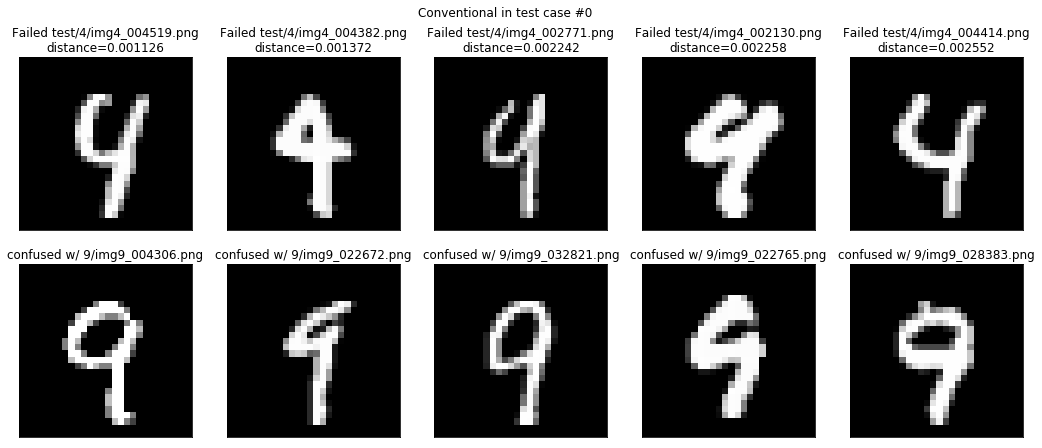

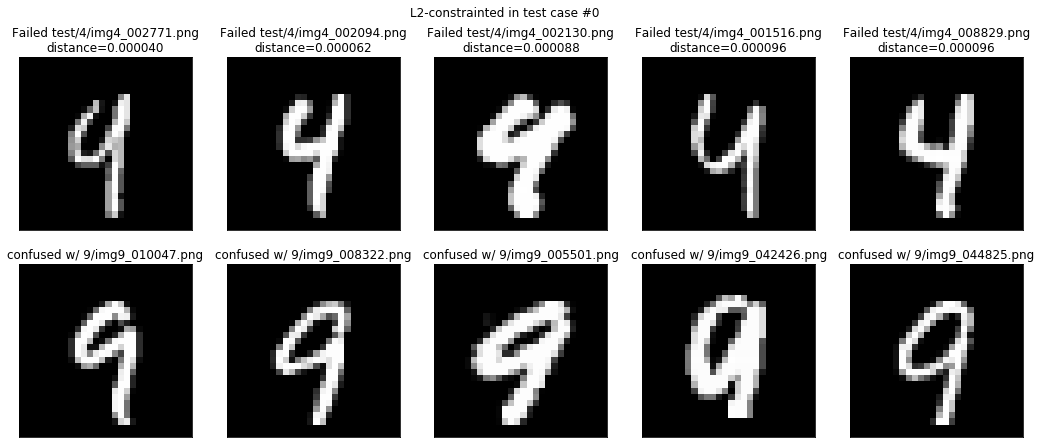

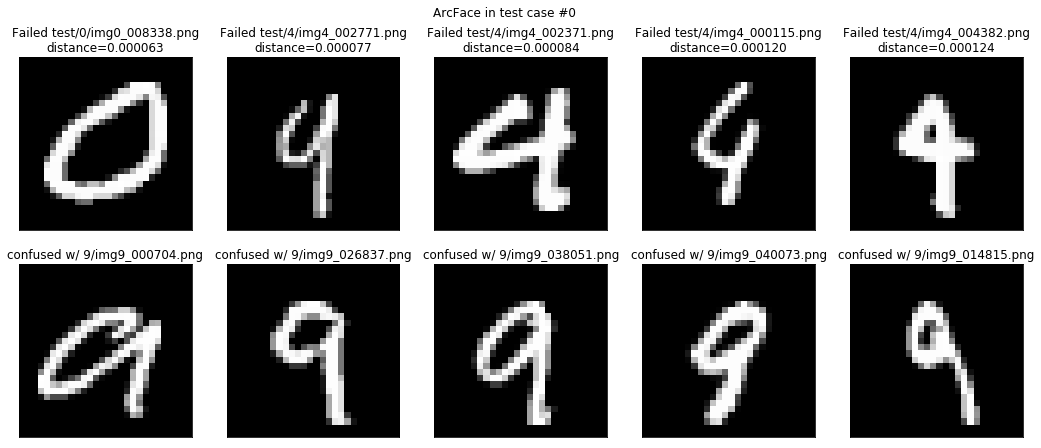

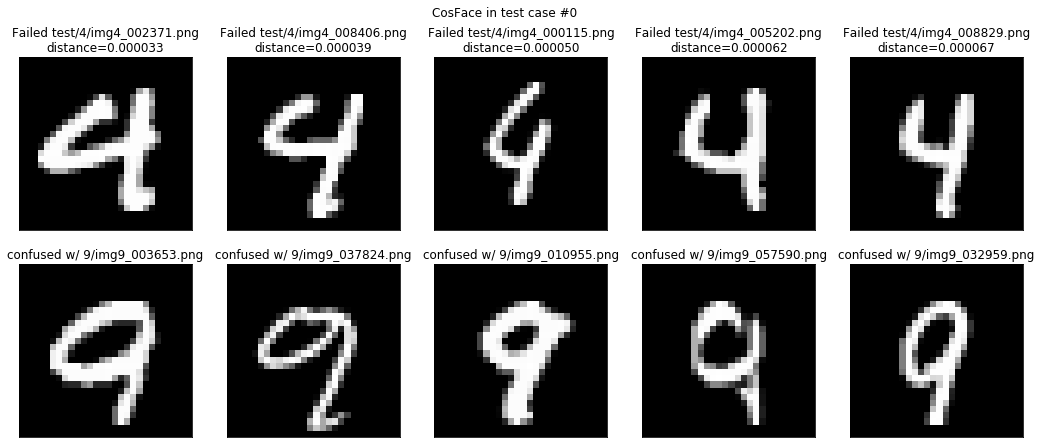

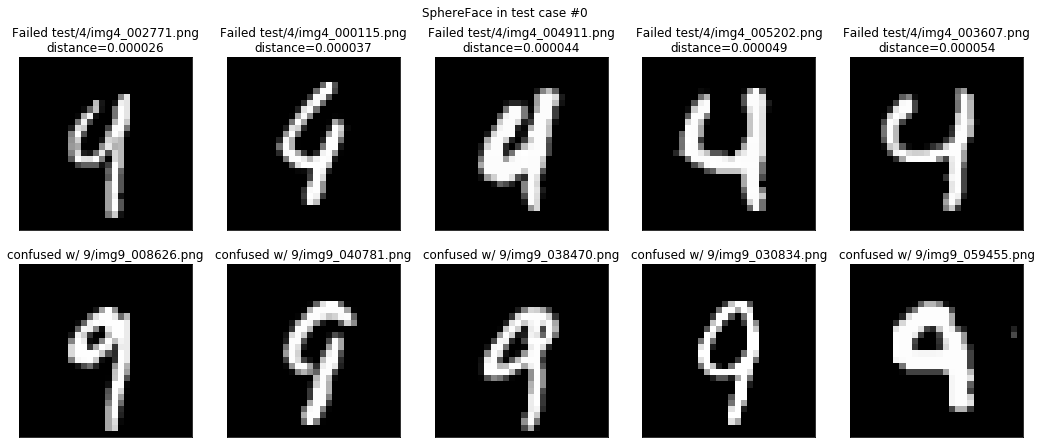

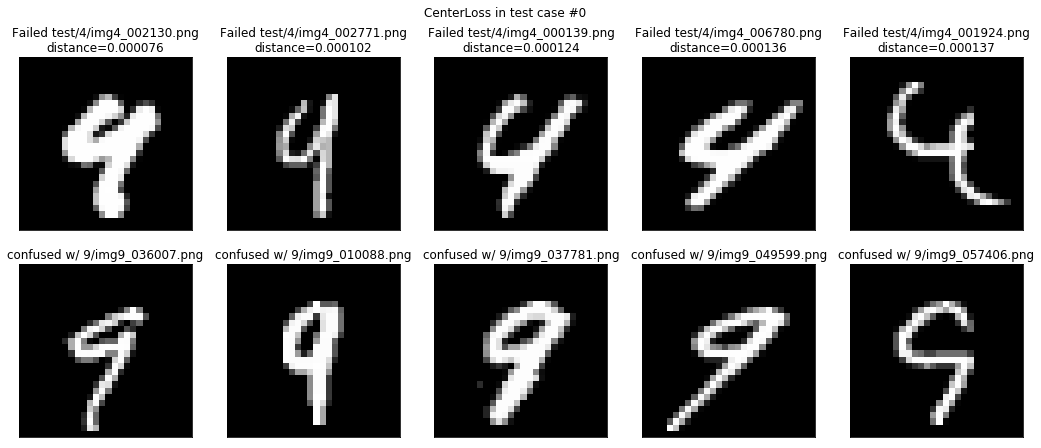

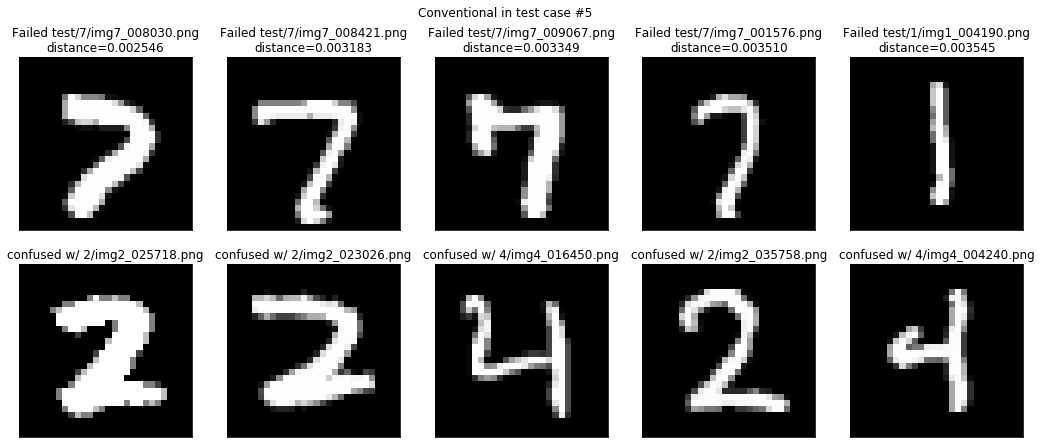

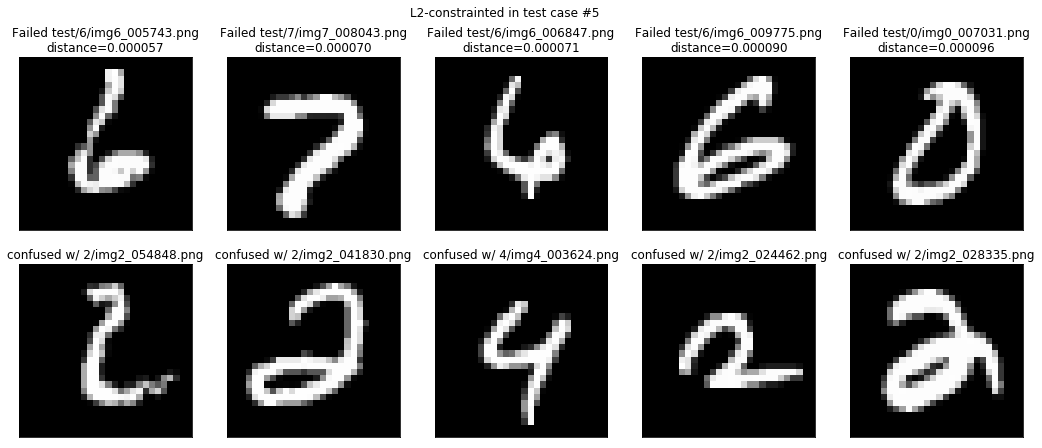

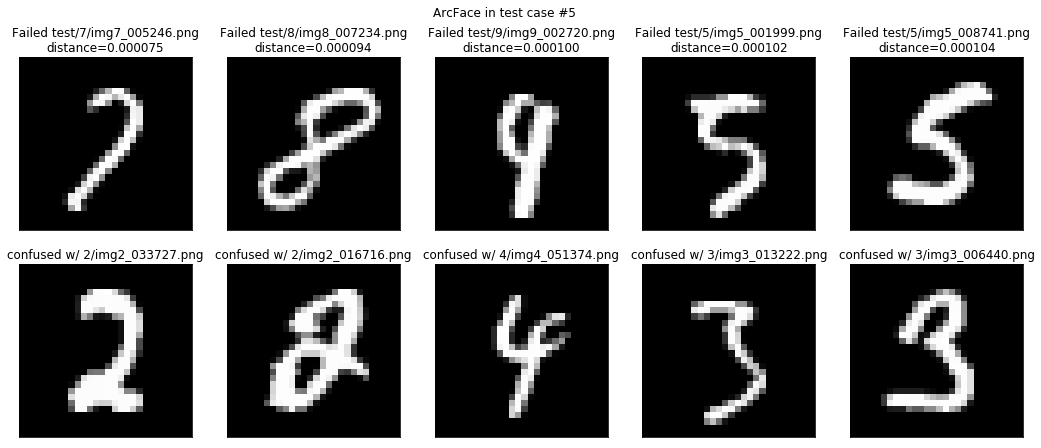

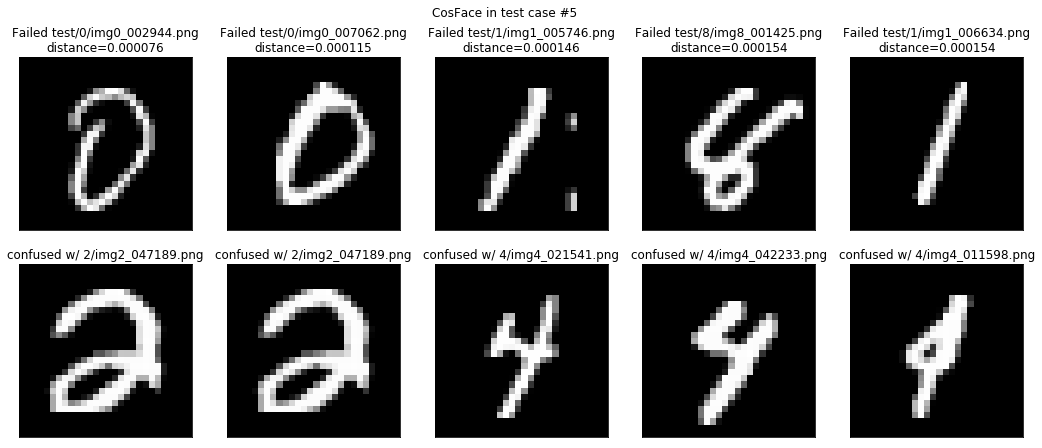

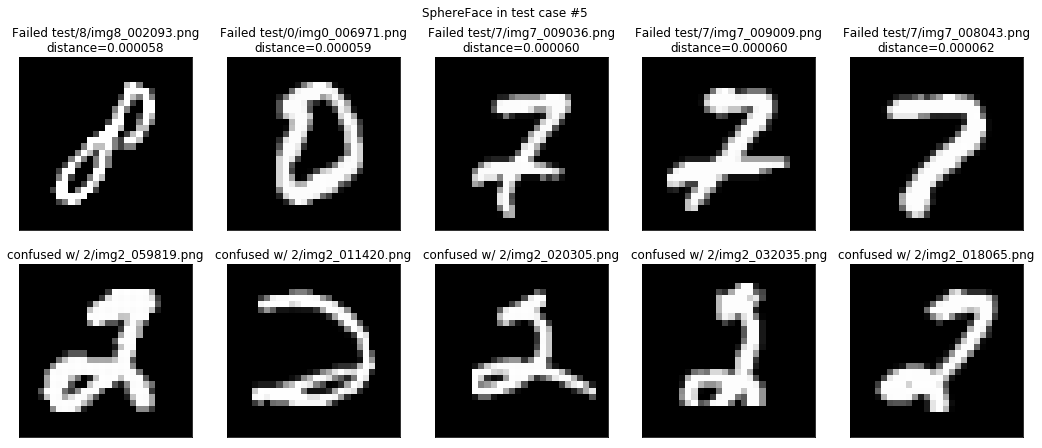

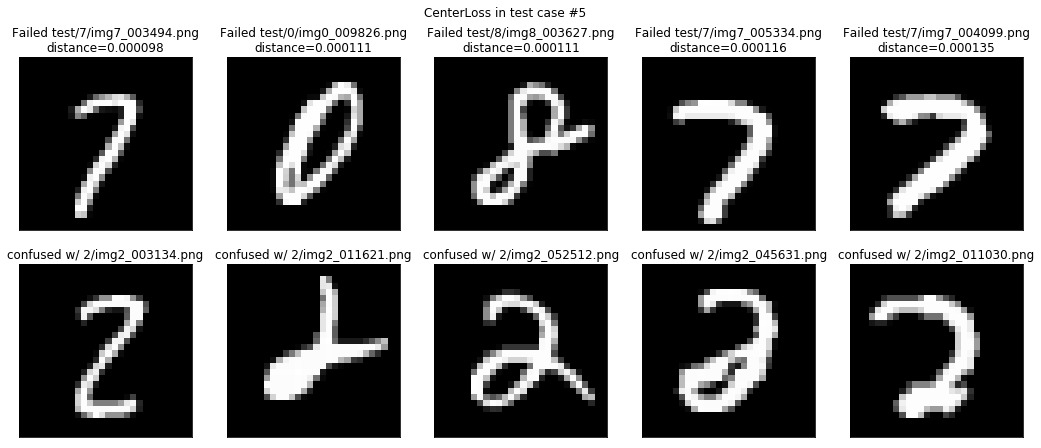

In [34]:
for i in [0, 5]: toytest.show_all_worst_test_images(i)